# TP 3

## Ejercicio 1

Un sistema de procesamiento digital de señales (DSP) se encuentra descripto por la siguiente
ecuación a diferencias:

$$ y(n) + 0.1y(n-1) - 0.2y(n-2) = x(n) + x(n-1) $$

Demuestre analíticamente que la respuesta al impulso del sistema y la respuesta al escalón
unitario son, respectivamente:

$$ y(n) = {1.5556(0.4)^{n}} u(n) - {0.5556(-0.5)^{n}} u(n) $$
$$ y(n) = 2.22222 u(n) - {1.0370(-0.4)^{n}} u(n) - {0.1852(-0.5)^{n}} u(n) $$


### Resolución

In [1]:
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

import sympy as sp
sp.init_printing()

n_to_z = lambda f_z, z, n: lambda k: f_z(z)*z**(k-n)

y, x = sp.symbols("y x", cls=sp.Function)
y_z, x_z = sp.symbols("Y X", cls=sp.Function)
n = sp.symbols("n", integer=True)
z = sp.symbols("z")

sys = sp.Eq(y(n) + 0.1*y(n-1) - 0.2*y(n-2), x(n) + x(n-1))

sys

In [2]:
sol, = sp.solve(
    sys, y(n),
    dict=True)

y_ = sol[y(n)]
y_

In [3]:
def fsubs(expr, funcs: dict):
    syms = funcs.keys()
    return sp.lambdify(syms, expr)(*funcs.values())

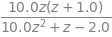

In [4]:
h_z_, = sp.solve(
    sp.simplify(
        sp.Eq(
            y_z(z)/x_z(z),
            fsubs(y_, {y: n_to_z(y_z, z, n), x: n_to_z(x_z, z, n)})/x_z(z))),
y_z(z)/x_z(z))
h_z_.simplify()


In [5]:
from lcapy.inverse_ztransform import inverse_ztransform

sp.Eq(y(n), inverse_ztransform(
    h_z_*z/(z-1),
    z,
    n
).rewrite(sp.Heaviside))

                               n                       n                      
y(n) = - 0.185185185185185⋅-0.5  - 1.03703703703704⋅0.4  + 2.22222222222222⋅1.

 n           
0   for n ≥ 0

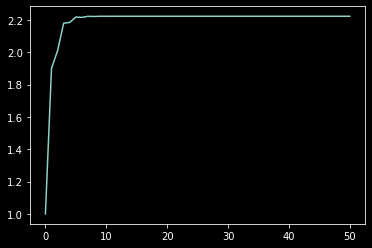

In [6]:
from matplotlib import pyplot as plt
from control.matlab import step, impulse, tf

z_tf = tf("z")
h_tf = sp.lambdify((z,), h_z_)(z_tf)
plt.plot(*reversed(step(h_tf)))


## Ejercicio 2

Un sistema discreto está descripto por la siguiente ecuación a diferencias:
$$ x[n] = 1/8 y[n−2]−3/4y[n − 1] + y[n]$$
Determinar:

1) La función de transferencia del sistema en el dominio discreto.
2) La respuesta al impulso del sistema.
3) La respuesta al escalón del sistema. 

### Resolución

In [7]:
y, x = sp.symbols("y x", cls=sp.Function)
y_z, x_z, h_z = sp.symbols("Y X H", cls=sp.Function)
n = sp.symbols("n", integer=True)
z = sp.symbols("z")

sys2 = sp.Eq(x(n), 1/8*y(n-2)-3/4*y(n - 1) + y(n))
sys2

In [8]:
def eqmap(func, eq):
    return sp.Eq(func(eq.lhs), func(eq.rhs))

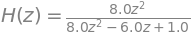

In [9]:
to_z = lambda expr: fsubs(expr, {x: n_to_z(x_z, z, n), y: n_to_z(y_z, z, n)})

h_z_, = sp.solve(
    eqmap(lambda expr: to_z(expr)/x_z(z), sys2).simplify(),
    y_z(z)/x_z(z))
sp.Eq(h_z(z), h_z_)

Respuesta al escalón

In [10]:
inverse_ztransform(
    h_z_*z/(z-1),
    z,
    n
)

                      n          n                       n           
0.333333333333333⋅0.25  - 2.0⋅0.5  + 2.66666666666667⋅1.0   for n ≥ 0

Respuesta al impulso

In [11]:
inverse_ztransform(
    h_z_,
    z,
    n
)

      n          n           
- 0.25  + 2.0⋅0.5   for n ≥ 0

## Ejercicio 3

La salida de un filtro digital de señales es la siguiente:
$$ y[n]=x[n]-x[n-1]-1/2y[n-1]−1.17y[n-2] $$

Realice un diagrama de simulación del sistema (diagrama de bloques) y obtenga la función de
transferencia del filtro, especificando el polinomio $A(z)$ y $B(z)$. Grafique el diagrama de polos y
ceros y determine si el filtro es un sistema estable o inestable.

In [12]:
sys3 = sp.Eq(y(n), x(n)-x(n-1)-1/2*y(n-1)-1.17*y(n-2))
sys3

In [13]:
def diff_eq_to_z(diff_eq, n, x, y, z):
    """
    Returns the system response in the z plane for very simplistic
    difference equations or recurring relations
    """
    x_z, y_z = sp.symbols("X Y", cls=lambda name: sp.Function(sp.Dummy(name)))
    to_z = lambda expr: fsubs(
        expr, {
            x: n_to_z(x_z, z, n),
            y: n_to_z(y_z, z, n)
        })
    z_eq = eqmap(to_z, diff_eq)
    h_z_, =  sp.solve(
        eqmap(lambda expr: (expr-z_eq.lhs + y_z(z))/x_z(z), z_eq).simplify(),
        y_z(z)/x_z(z),
    )
    return h_z_

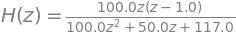

In [14]:
h_z_ = diff_eq_to_z(sys3, n, x, y, z)
sp.Eq(h_z(z), h_z_)

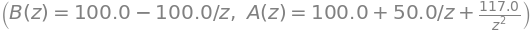

In [15]:
a_z, b_z = sp.symbols("A B", cls=sp.Function)

def num_den(expr):
    expr = sp.together(expr)
    return sp.numer(expr), sp.denom(expr)

h_num, h_den = [x.subs(z, 1/z) for x in num_den(h_z_.subs(z, 1/z).simplify())]

sp.Eq(b_z(z), h_num), sp.Eq(a_z(z), h_den)

## Ejercicio 4

Defina tres funciones de transferencias de sistemas de filtrado digital que cumplan con las
condiciones de estabilidad, inestabilidad y estabilidad marginal. En base a estas $H(z)$ propuestas
y el software de simulación que considere oportuno, realice:

1. Grafique los diagramas de polos y ceros de cada función de transferencia, y demuestre en
base a ellos, la estabilidad del sistema.
2. Genere una entrada que deje en evidencia la estabilidad del sistema, y grafique la entrada
y salida del mismo.

## Ejercicio 5

Defina que es un filtro FIR e IIR, y escriba con sus propias palabras las ventajas y desventajas de
uno respecto al otro. ¿Podría citar ejemplos prácticos en donde sea conveniente implementar uno
u otro tipo de filtro? 

## Ejercicio 6

El método de diseño de filtros por muestreo en frecuencia implica tomar muestras en la frecuencia
para luego, mediante ellas, obtener un filtro fácil de implementar ¿Podría decir cuál es la principal
ventaja de este método que lo hace único respeto a otras alternativas de diseño? 

## Ejercicio 7

Se requiere un filtro FIR elimina banda con las siguientes especificaciones:

* Banda de paso inferior: $0$ – $1.200 \mathrm{Hz}$.
* Banda de atenuación: $1.600$ – $2.000 \mathrm{Hz}$.
* Banda de paso superior: $2.400$ – $4.000 \mathrm{Hz}$.
* Ripple en la banda de paso: $0,05 \mathrm{dB}$
* Atenuación mínima en la banda de atenuación: $60 \mathrm{dB}$
* Tasa de muestreo: $8.000 \mathrm{Hz}$.

Determinar:
1) La ventana requerida para el diseño del filtro.
2) La longitud del filtro FIR requerida.
3) La frecuencia de corte para las ecuaciones de diseño.

## Ejercicio 8

En un sistema de grabación de voz con una frecuencia de muestreo de $10.000\mathrm{Hz}$, la señal está
corrompida por un ruido aleatorio de banda ancha. Para removerlo, se proponen las siguientes
especificaciones:

* Rango de la señal de interés (voz): $0$ – $3.000 \mathrm{Hz}$.
* Rango de rechazo: $4.000$ – $5.000 \mathrm{Hz}$.
* Ripple en la banda de paso: $0,1 \mathrm{dB}$
* Atenuación: $45 \mathrm{dB}$.

Determinar:

1) La ventana requerida
2) La longitud del filtro FIR
3) La frecuencia de corte

Utilizar algún software de simulación para diseñar el filtro y graficar la respuesta en frecuencia.

## Ejercicio 9

Un ingeniero de audio intenta ecualizar una señal de voz muestreada a $8.000 \mathrm{Hz}$ utilizando un
filtro FIR de fase lineal basado en las especificaciones de magnitud de la figura. Proponga una
posible solución y, utilizando una señal de audio con voz humana, muestre gráficamente la señal
previa y posterior al filtro.

![](./res/tp3/ej9/plot.png)

## Ejercicio 10

Un proyecto de detección de actividad ilegal en áreas naturales protegidas de Misiones busca dar
aviso automático a las fuerzas ante eventos de caza furtiva y extracción de madera nativa. Para
ello se necesita diseñar un sistema de monitoreo acústico que permita identificar sonidos de perros
en actitud de caza y motosierras. Se han grabado estos eventos y se requiere diseñar un sistema
digital que, ante una señal de entrada (proveniente de un micrófono) permita aislar ambos sonidos
para generar una señal $p(n)$ asociada a los perros y otra $m(n)$ asociada a las motosierras. Tomando
como datos las señales `grabacion_perros.wav`, `grabacion_motosierra.wav` y
`mezcla_perros_motosierra.wav` del aula virtual, se pide:

1) Describir frecuencialmente ambos eventos mediante su análisis espectral; comente, por
ejemplo, si existe solapamientos en algunas bandas y si es que estos sonidos tienen algunas
bandas específicas en donde concentren sus características.
2) Diseñar y simular un sistema digital de una entrada y dos salidas como el de la siguiente
figura, el cual alimentará una etapa de detección posterior. Probar el sistema con el audio
`mezcla_perros_motosierra.wav`.
3) Graficar los espectros de entrada y salida, y si utiliza filtros FIR, especificar y justificar
detalladamente el método de diseño, las características de los filtros, su orden, atenuaciones,
ripple, frecuencias de corte y ventanas utilizadas.
4) Bajo su punto de vista: ¿Cree usted que es posible implementar este sistema en la práctica?
¿Podría aproximar un porcentaje de eficiencia del mismo? ¿Qué sugerencias o
inconvenientes encuentra para que este sistema pueda tener una eficiencia del 100%?

![](./res/tp3/ej10/sys.png)

In [18]:
from pathlib import Path
from scipy.io import wavfile
from utils.misc import Audio, mono
from numericalunits import Hz, kHz
import numpy as np

resources = Path(".") / "res" / "tp3"
r_ej10 = resources / "ej10"

utext = lambda unit: f"[$\\mathrm{{{unit}}}$]"

mot_freq, mot_dat = wavfile.read(r_ej10 / "Grabacion_motosierra.wav")
mot_dat = mot_dat.astype(np.float32)/max(abs(mot_dat))
mot_freq = mot_freq*Hz
Audio(mot_dat.T, mot_freq/Hz);

## Ejercicio 11

Mediante el diseño de filtros IIR por el método de polos y ceros, se pide que se diseñe un filtro
(o varios) del menor orden posible que permita eliminar los armónicos de $100$, $150$ y $200 \mathrm{Hz}$
vinculados a la señal de la red eléctrica. Los anchos de bandas de rechazo de cada armónico deben
ser de $5\mathrm{Hz}$. ¿Qué frecuencia de muestreo sugiere para su implementación? Grafique el diagrama
de polos y ceros, analice su estabilidad y obtenga la ecuación a diferencias que permita la
implementación práctica del filtro.

## Ejercicio 12

La función de transferencia de un filtro analógico está determinada por $H(s)=\frac{10}{10+s}$.
Utilizando la transformación bilineal, obtenga la función de transferencia del filtro digital
asociado a $H(s)$ y que trabaja a una frecuencia de muestreo de $100\mathrm{Hz}$. Además encuentre la
ecuación a diferencias de dicho filtro y determine si se trata de un filtro estable o inestable
mediante el gráfico de polos y ceros.

## Ejercicio 13

Diseñe y simule un sistema digital de filtrado que, con el menor orden posible, permita
atenuaciones mínimas de $60 \mathrm{dB}$ a señales que superen los $500 \mathrm{Hz}$. Además, la señal que se desea
filtrar debe sufrir la menor modificación posible en la banda de paso, la cual está comprendida
entre la componente de CC y los $250\mathrm{Hz}$ ¿Qué tipo de filtro recomienda implementar, y de qué
orden sería? Grafique su respuesta en frecuencia (completa) y simule su funcionamiento con una
señal de entrada $x(t)$.

## Ejercicio 14

Se debe diseñar e implementar en un DSP un filtro IIR Butterworth que funcione en tiempo real
y que permita eliminar la componente de $50\mathrm{Hz}$ inducida en un enlace de datos de baja frecuencia.
Las especificaciones aclaran que se requieren como mínimo $35\mathrm{dB}$ de atenuación. Obtenga la
ecuación a diferencias que se debe implementar en el DSP y simule la efectividad del filtro.
Grafique además un diagrama de simulación en donde se vea la implementación práctica de la
ecuación a diferencias.